In [1]:
import json as json
import matplotlib.pyplot as plt
import os
import numpy as np

import multifil
import treatment_definitions as td
import graphing_utilities as gutil

# List valid things that can be changed
print("valid constant (phenotype) parameters\n", multifil.hs.hs.VALID_PARAMS)

imported myosin multifil
valid constant (phenotype) parameters
 ['mf_k', 'mh_c_ks', 'mh_c_kw', 'mh_c_rs', 'mh_c_rw', 'mh_g_ks', 'mh_g_kw', 'mh_g_rs', 'mh_g_rw', 'detachment_rate', 'mh_fd_k0', 'mh_fd_delta', 'mh_iso', 'af_k', 'ti_a', 'ti_b']


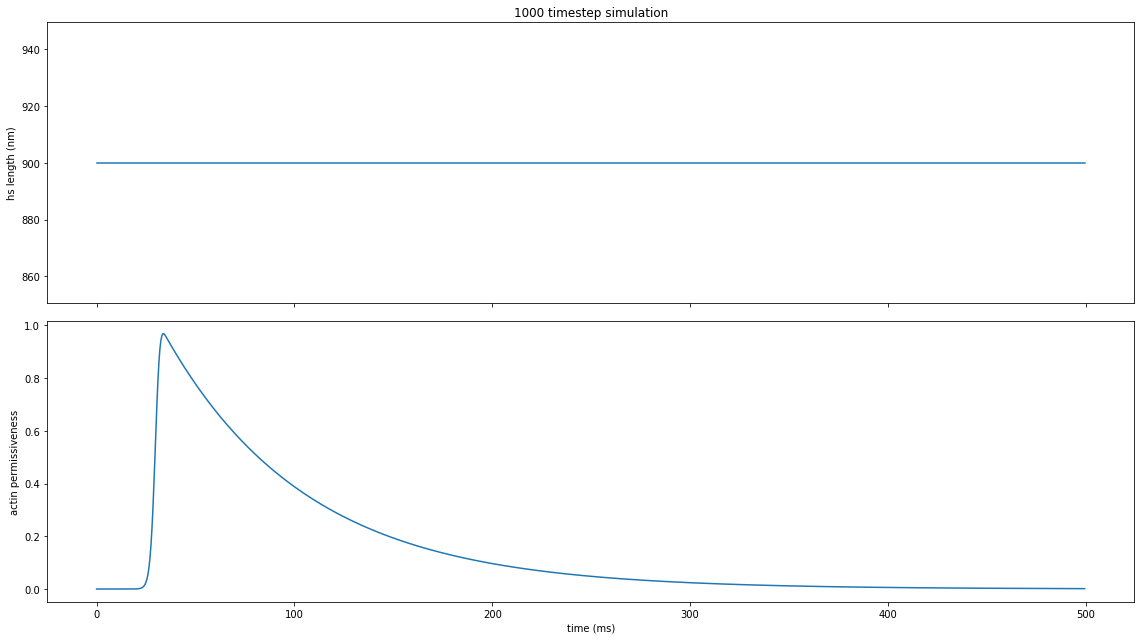

In [2]:
# Setup experiment, show the traces
time_trace, length_trace, actin_permissiveness_trace, params = td.stiff_torsional_spring()

#plot the traces
gutil.plot_input_traces(time_trace, length_trace, actin_permissiveness_trace)

#print the phenotype settings


f41d101c-6404-11ea-8fc7-185680feb82e
name
comment
path_local
path_s3
poisson_ratio
lattice_spacing
z_line
actin_permissiveness
hs_params
timestep_length
timestep_number
{'detachment_rate': 'force_sensitive'}

MainProcess finished timestep 1 of 1000, 0h0m40s left

C:\Users\Anthony\Documents\github\fd_multifil\multifil\multifil\ti.py:171: UserWarning: Check radial force direction in titin
  warnings.warn("Check radial force direction in titin")


-1.7971594063107545 -1.7970939870367033 -6.215615660431411 -2.8888676077098694 -1.799987303246894 -2.890087214872608 -3.988769429421609 -6.215590627562108 -2.890083973236017 -4.0015202315847205 0.7158618666670691 -1.7989598867511631 -0.5135669924462718 -2.8915390679881625 -1.164698587696762 -3.9347197780006695 -3.26965280743309 -0.31361272311119137 -1.7948393339698328 0.9640398209062369 -4.779050133061446 -2.883441547071243 -5.505039361538223 -3.9699086217229933 0.7362654631256191 -0.3090161689200954 -1.8085253465060873 1.1631884790485856 0.8916783368767938 -0.916098431444766 -0.5090204123465583 -0.5460042458003045 -2.9041880953650434 -1.171270813772935 0.6191480787775276 -3.9451229988932823 1.939592640231922 -3.3035814468488525 -0.3315488707659142 -1.8437133540094237 2.6594282427113285 1.1139728380895804 0.8925080032363439 -0.9153213731673304 -0.5081450993288854 -0.5455486713181017 -2.9223653056336047 0.46813475989495146 -1.1567322311462078 0.5956427388234147 -3.913851072280977 -2.733

 -3.9329707666407785 -3.415058049139816 -2.5605775636809085 -4.007644240815921 -5.230840565028757 -0.9091031926989217 0.4206335292582821 0.696255860238125 -1.2666144031513227 2.0056906681822397 -3.800886181505348 0.12300326565815567 1.4466895092796221 4.272429893719618 -4.5094568669693444 2.1047615132688406 -4.060208632866306 -4.689965126111474 0.5181909445994961 4.305549597080471 -5.540161423365674 5.037018233103225 0.45626622172076736 -4.194099004469592 -7.8836155986107315 1.164926060067728 -2.741694683577407 0.7303887632820647 1.4790708536662578 -1.4515478439053595 -1.3026738437747554 0.12070645258984314 0.9317010040016385 0.3144704105349092 -1.3610810391753603 -2.483907812451662 0.24224572836499192 1.2328177736837915 5.942196985842202 -6.00629881179006 -3.5658468072093967 -1.9675531695262123 -3.0123521031280234 -0.11413695264701573 0.5449282496380761 -5.965142367702981 -0.3602018744402926 -3.8334774488600374 -0.7632365625092348 0.8032274535107149 -2.2523733365474072 0.3563623730772

 0.5379579669760233 0.9305192521950403 2.788449542795604 -3.479366996177191 -2.221778043166978 0.047404419761278405 0.5963873792487675 -0.46756825541569924 0.25768811663567703 -1.0917978795445151 0.32527231507856413 -1.5926733832169475 1.112309731486448 -4.506579965916217 0.4400817838669582 0.44200295755740626 -2.2317033958206594 0.43018347814177105 1.2151600122469972 -1.7237855228518697 -3.418951899585011 -2.2568900091858666 -1.735885237381467 0.30354805439264965 -1.405427157611939 -1.440440986248575 0.8843933020814347 -2.196466630310283 -3.1475567084941076 -3.792387530006067 2.8520854065686763 -0.34731066219217155 0.2703635240465019 -2.368010388875973 -0.5687198579666983 -3.926026922072424 0.44742894438286385 2.041220590767807 -3.48884511969527 0.6075987834010448 -2.680648919541966 2.227024143633912 -0.8996305472573738 -0.07497462764393958 -3.1313409941181476 -2.509282576030273 -2.122179255185813 -1.206037028554988 -3.486218831491101 -0.3933059931165417 0.5631981337768366 4.253696715

 -2.709381059652287 -4.810786483116431 4.113748677871854 0.4421264403507621 4.314463901135241 -4.314283833661989 0.413940435158338 -2.6411316630740203 0.4091671229990652 -2.093373375818828 0.2898159544989767 -1.0753904668205223 2.2946564290280094 0.32782325083678643 -1.6686085729365914 0.49961693455048817 3.8365858723978477 0.8399187151930221 0.41026297782653387 -3.748248457508282 -1.3755826426429394 1.816275978125816 4.294019583288957 -3.542246438348684 -4.83319772266816 -0.574810548428843 1.2123270130870196 -2.0566766557765277 -2.597411498143856 -1.9707897134545647 4.672819125146589 -1.9129734125839377 -0.14112205513185927 0.2139297684009307 0.3836314948641757 0.4105760943293717 -6.057164920754275 0.4581145611832653 0.4255344136090855 0.41243156141933923 0.9704033349466386 -0.3676610706646102 -3.434376722699369 -2.3616728102070965 0.1413984144104461 0.4210204811730591 -0.33932517311961874 0.3045151448220622 -1.3284001906727099 -1.0237021354309945 0.34709871377094714 0.321273437014724

 -0.5973707526650855 0.5866893856207298 -0.288309575546009 -1.1053388980493537 -0.8422617408039059 0.5398456891327896 -3.612390310245587 -5.849800922056033 -2.6405475296321583 0.5220794934757578 -1.9023190424336462 -3.4492090300691416 -2.242059112539323 1.5092126601396103 -1.4557003446609826 0.6332523049385372 -1.9405654568789146 -1.6419185341854927 -0.01866635696154617 -0.815118897298305 0.7301498942568969 -2.064949530031697 -3.071468760291225 -1.6350976483865338 -1.4299346684718444 -7.6344592263453706 -2.7997420810951326 0.5648901638472807 -0.18912239545591092 4.559055280036205 -2.1038446163887556 0.41283861419572077 4.8664158333494925 -1.4637753482514881 0.5156272652205871 0.7773867828942684 2.143986667545903 -0.9228251946043144 -3.53059728435602 0.33940845914366946 -6.30718868974833 0.7603365088905889 -2.6483752271541334 -2.7078784195097114 -0.5891476241263263 0.42673142130968245 0.3764290454126922 1.1180217484036348 -2.2111943578943283 4.327442823342722 -1.9720217513494163 -4.0092

0.5169981150710328 -1.677059724076429 0.31573882945454557 0.4980674019420235 -2.939175497202882 -0.8065852199146661 0.5131576960467896 0.8539889193783097 -6.868018424662239 -0.509673253562994 -0.02073891036468467 -2.022208248101151 0.2292936323400454 0.6052194502813109 -0.23484512929451284 -1.112166240865804 -0.8209183330834549 -1.5738271172079976 0.5796318650072863 -5.7981395870651795 -2.5830890014884744 0.49505008911955883 -6.493823089687453 -1.5520885746151407 -3.261952877137844 -2.0502692193833525 -3.8131441911003208 -1.6326481842356202 -0.032660065587549525 0.6342034542994952 -2.0596985624532067 -6.909403343047359 -3.297928564286849 1.0209693669253852 -1.4213911700726953 -2.820253917184573 5.584272461770524 -3.771589038840375 -0.1670639899851949 0.49820735834850893 0.49188831183801085 4.892674940516372 0.5244290714667841 0.821127449456867 2.090447272343937 -3.50327883575477 0.3325098872136891 -1.7769015918515834 0.7431594330769826 -2.503740693513521 1.6577813647432436 -8.329942531

0.2620285113887917 -3.798769346244626 -0.7129434839010287 0.29085693775607524 0.8801667894558136 -0.6227901117824786 -0.010129801954178674 0.21467954116985766 -2.03921779180007 0.10973169662759119 4.84900064715157 -0.3904970843951787 4.13685388248291 2.334946709809401 0.09096293523862187 -3.720083017061029 -1.4771247396454328 -2.7963885409657223 -4.25771792965611 0.08988999930102182 -2.109845468099934 0.09310514736773712 1.466666846478006 -1.3456325546800088 -3.3562715333134747 -6.407554353901361 -1.4766163377222483 2.6439651816012884 -1.0826991569035727 -3.7261284865044786 -2.8018121156362668 -3.3712104491917216 0.6369812245640105 -2.747455114601621 -1.1007446127462686 -2.603371973754406 -3.7985610266571257 0.7218967834033947 -3.3719646475802847 -1.7905777045061768 -4.3980817543179 -7.4669010097359205 0.6762536710870108 0.8439078872214623 0.6624019774127419 1.0538543042824813 -4.033469228264153 2.084640845114137 -4.20323275418383 -1.492478200683479 0.8494782898586664 -2.07849964033738

MainProcess finished timestep 101 of 1000, 0h1m48s left-0.793503072021565 2.509759566288807 0.5077926707249105 -2.899751173000766 -0.9302346980694551 -2.535104125865473 5.0188809230137394 -2.1644843466658585 0.8437339258311454 0.17636476453435534 -2.7938009864448645 0.16781855238662047 -4.660829154550356 4.379094366248864 -0.999157948541324 0.5265506283924424 -3.6721619966655226 1.2896486362518544 -4.14252867001926 0.5211121367244687 -1.9556709181532597 -2.679491793096531 -2.2821085578929114 -5.600076087479039 -1.5921175541034813 -1.639886314873877 -4.091104252710807 0.38373481269240983 -5.75425711480375 -3.830807162062513 4.263665012486399 0.3787616572734578 0.9651802111816323 -5.837993440401306 0.29933873825382307 0.7489226877273722 0.3570291198029736 0.3425311893579419 -2.033648780417252 -0.47558656311116465 -3.109550510932195 0.5486713726015751 -4.179619361955474 2.508152734994269 0.2888539250769213 -1.8282282870635527 0.8741174653796975 1.5930133121800054 -1.418682605251945 -3.726

 0.8168405434909118 -2.078031802862256 -0.43048576754074475 0.22657717535582833 -3.0591634991714045 1.747719485375569 0.26493744131346375 0.4756138640758536 -1.1362500150925143 0.28714827781436725 0.4897110944327778 -2.6477231701406936 0.2957134420133798 -1.9839904473060415 -2.7485260699684204 -2.325673704467931 -1.3354896136349907 -1.8016063930263044 -8.196281695275275 0.19232880870009694 0.36821927993076997 5.238790799445667 0.5086517460838991 0.44190394169936553 -1.1430092428194598 0.48960300639134857 -7.3007772944998806 -2.7354273544370926 -3.556102155583744 -0.03143799504653089 0.4351865577166336 -1.9079839078948453 -4.504498218166418 -7.589533710795422 0.46851116841594376 2.285439013622522 -3.167375521558597 -3.8521135117081258 -0.7282617620655003 0.5511314593096586 -6.379660779888582 -3.0912963039178862 -2.1782033314951263 -1.1951630155798512 -2.4510681748803336 -0.3447362768323501 -3.4021409974277503 -3.33082376187258 0.3410295831941994 0.23921596093259723 0.567186613199965 -6.

 -3.3336491332094056 0.8146925411397774 -2.085534313843027 -2.9477521544590672 -0.4294321730312731 0.22586620463408735 -2.0369547880363825 0.2289947496417426 -1.161851214090916 0.8182141447396134 0.48963457365812246 -1.0032719997200275 0.6702389040577827 -3.586245008519768 -1.3048805010422484 1.3621697416058396 0.6457494546363023 -1.8890460949297676 0.5857479877224705 -2.221373696411092 -5.703735002849442 -1.720285660054003 8.33006239596574 -3.9405106787046975 -0.08244591466348083 -0.7922265619401401 -1.2018736793937137 0.3158935662793283 -2.9597268710933236 0.4118839207127962 -2.0881356195095577 -2.965961256078799 0.4005634217867282 0.22258620808213436 -0.25526959833382534 0.36562541175840124 -2.161254086021586 -3.294550944617413 0.38016572344622546 0.8570395297671212 0.2098173936233252 0.688355118194977 -0.9133000067694184 0.8160808681652156 -0.5452779691005958 -2.4096457221520495 1.3687291586697938 -3.471307019808478 -0.4062123063500849 0.367712632779444 -3.4221473805539517 0.608619

 -1.3345602806725765 -2.1081480899929375 -3.055504805890223 0.4500695499639278 0.3780327558963563 -2.171348098496651 -3.093779922957765 -3.812837237997087 0.8979207639308697 0.37702802788442114 0.7492470774826643 -0.9596240949098842 -0.2523376425644983 2.2486045318522656 0.2764718671509172 -2.6313330645737096 -1.33650957044307 -0.4290117278709431 -3.6671854446518637 -2.241752766685636 0.033723677188049805 0.4612429271568317 1.2195349124273207 -0.026175978082505935 -6.707360971391722 0.2990314079603422 -5.5154623484580725 0.3349668794161289 -1.6366507849601248 -1.9896775150253632 4.929797056749692 0.2847738076944495 -2.0235202957061347 -3.146851776184974 3.1576215814125703 1.9680532289265216 -3.6631498460722014 -0.35323198927949306 -0.6269227937022492 -2.143855817405665 0.49668586939401393 0.0671683715099789 -3.3272059797136535 -3.7134027308834447 -0.01475582137152287 -3.2980294596560498 -3.8823443410244636 -2.3204209320831524 0.47992894720349 -0.8671121889345841 0.4728106171217803 -3.0

 -0.647074737685557 -1.2229283792391925 -2.0166600197325124 0.12944959153492164 0.3253441116122531 2.215190973411154 -3.905691795700136 1.2285087943107555 -6.051235993882898 1.225044444762318 -1.4376877028340687 0.4548980107654188 -3.3190034728899604 1.7320316386939112 -3.462626271122417 0.8107562613989217 -6.086550619852176 0.3330372105730248 -0.5223260722616487 0.32540190484655795 -0.7453372721971618 0.32845751838112847 0.7862456854595621 -1.3416891636595665 1.940328388696912 0.47567686485399463 -4.040077970953462 -0.8558840843299151 -0.31020607336643025 -3.4896612479270175 -1.2536722790378008 -2.081155561110677 -2.2079717939324723 -2.7173143778742883 -0.4373315533453024 -1.8316550546122699 0.363140857322378 0.3854034605343486 -0.13141394166882492 -3.842610218989307 1.0856234668175375 0.598038473823749 -2.1889761262056027 0.5418889937952827 0.4727309666192241 -1.8011455654243491 -1.2795621915586253 -6.414044204035179 -0.3192017228029158 -4.164860456976896 4.974692772090407 -0.9395709

-0.9545029160977094 -0.7400685749431943 -1.7763426045252686 -3.007053853508637 -0.9613759656631373 1.2836115722953991 2.9185261523318218 -3.9310113933969433 -4.142549501779854 0.7780258905018513 -2.297845430686891 0.8964079336078612 0.1101500770007533 1.5699027311960663 -1.418466340890518 -4.881531562580562 -1.0053048674976708 -1.803169507654161 -3.924881639321484 -2.923629885426294 0.4159908393596652 2.3387980766641476 0.5285291318299414 1.3714028977439057 5.648207278290101 -0.14378305316131446 -0.9786293973854754 -5.785948869319952 0.5543774276935096 -3.1488469383134543 1.6131376195220923 -3.828059168030336 -1.8237768967237002 0.8387718671570497 -3.061474394306174 -3.8159088221253796 0.24892017131378452 0.23767079925266898 0.816891425632889 2.7519510228030413 -1.2516920423283864 -1.6671991484231512 0.5721789671764554 -3.673151983840853 -1.3859465920564276 -1.894272264751237 -4.2666479560149355 -2.7680724289168097 -3.6380286357817795 -3.7627527855239578 -0.7055435705499349 0.313523082

 4.553891238808546 -1.3141397230376697 -6.530157969699047 1.5725688117328218 -0.9538155507283079 0.8162348369862684 -3.851634256177931 0.32831234878335636 2.251934705605663 -0.7423233537896863 2.2278188901226486 -2.3963473729111797 -0.5934190558797354 -0.5942080377085972 1.2746224308025376 -1.8161153179676148 -3.5668597815393923 -1.8425084351719079 0.2554139233900514 -4.291722697893647 -1.4206606682873826 0.46473409109751174 -4.357937977121537 0.7406092753789153 -1.1101605371269443 -1.7081510397722184 -5.339258381651831 -1.7595094276838097 0.5037949130855282 -2.67807280447704 0.43313453031913696 -3.4138152157965465 0.7041645578547104 0.8797261223604664 0.003471284815816489 -0.6122924971232919 1.5086141524500363 -1.33053568035416 0.42944670243525707 3.005660507385869 -1.804693822117315 -3.968978431735195 -2.8712849741090167 0.42138637830248626 4.566673466854013 -2.5575455093282926 -2.320796872262065 0.12058192501814347 -4.156447109722137 1.9925139140991632 -3.156274787719724 -1.33143674

 -2.5095817565572816 0.4372002142547444 1.1715733249086497 -1.72804663166022 -0.07127920403820553 -1.5600080079360623 0.6026970708070394 -3.668639802362179 -0.641058467245557 -1.9413766551836034 -6.127754532098322 3.639012948359209 -1.9481454190765817 4.746573466051245 -0.5973275555143118 0.2258795990986755 0.8483649934747746 -0.4657861304774542 -5.676331130020117 -3.777491934135412 0.3709201681819536 -2.108948925919492 0.736820499911687 1.4450766155460428 -2.281879298549711 1.1847796979871532 -0.6383281478509844 0.5139069871971742 0.21679137992305186 2.0593189989889424 -0.2533518055837476 -2.983818154546725 -1.3107497845943499 -1.3573498130122061 0.5048711597666795 0.7164484206359418 0.17722609515811882 -0.7456503570445534 1.032407771737894 -3.810924517053877 -3.2196467911120408 1.7020590042756112 2.0353333998436938 -4.065739863399699 0.5388205710503371 -5.910873474723417 -2.059319978524371 -5.52201264835719 -5.27754476631867 -1.6359389408155778 -0.8881257619648295 -2.523408390313932 

 0.6792722143601395 0.7419642984970096 0.46993277675892386 -2.6343085572325435 -1.9627339568212392 -3.220460201334845 5.784892918634682 -3.38315107400021 -0.47068132844006527 -1.6559285716715522 -0.13547880811120194 -5.83038581411779 5.022263331919362 0.2879550218658551 1.8435306926720614 -3.3896208560672676 0.8929714057784963 -1.6615452571472247 -1.8483788525735463 0.37379956312940976 -2.382566344794327 -0.642063177423438 1.1927652523521601 0.3871266320339828 -1.2284281512935422 -1.677440278569179 2.0023927828849537 -4.505261008061069 -2.9104524333876896 2.2493398404105847 -0.1917038497394401 0.49835104563914 -6.394659319270488 0.8265946695074149 -1.9895286890006219 -2.0183847948108564 0.5103652855099199 -1.7957563070409606 0.5893118825031252 1.730338890703706 -3.3301909961537604 0.11183133569875281 0.5501526459619299 -2.641939821762321 0.7089841765321125 -5.421696404795853 -5.528530511480312 -2.084930022173353 0.39163325344901523 0.6908604690207198 0.34898226270948385 0.3408584176881

-1.7362250851005 -5.25209732366838 -0.916101859546302 0.4082794197226747 -1.2925802811141693 -2.748231876239288 1.2769573827884528 -4.938680205999731 0.5464502131765698 -2.4142789881400972 -2.4360034480720287 -0.4300058522496215 0.018812544190268454 0.823501186844851 -4.859859909184138 0.3190150798147897 -2.7711942601956707 -4.321642816966914 0.2757956204226275 1.4429935897881023 5.6538955788875 -1.9240997873342849 -0.1288583545911024 -1.559481237531486 -3.669951829259844 1.513197355869977 -3.886036287980403 0.2423702729781212 0.18516848298747846 0.12599564785989514 1.5032967300334121 1.1820831835377703 4.400935463768747 -1.3600622410854157 -1.7110049596153658 -4.593044468592581 -1.1863864679523601 -6.07234639913986 -3.1637094146610707 -3.8508720718980385 1.6540793208393438 -3.241472582653955 -1.8060165465742557 0.6226360707335061 1.8221369156377705 0.4933491973075661 0.5035641020805315 -2.5595424615004276 0.04149321766101366 -5.359494190621945 0.4496885065703964 -5.487434098751805 4.6

-5.573407550404966 -0.9247838901045498 -1.5551309974391927 -2.7832335707835796 -2.484814059329949 -8.17802069467524 -0.44061449935259134 -4.061201881890156 0.8496149054514035 -4.668565522295353 -1.7231608412107562 -3.7687312810592175 -1.4559347305516894 3.234760423454645 0.595771581245458 -2.3989930016517746 1.5067972041430266 -0.7327895158440185 -1.742478327715844 0.057555351998303195 -1.5425115652294608 0.2905868051384459 1.7708518486751927 -4.086233565723717 -3.4730547836762753 0.8516554452410219 -1.500688593626876 -3.2929802134613055 -3.234855960879486 0.32330183676731394 4.514988574266454 1.1737715805531934 0.27961163304826187 0.5273196635251907 -1.5149744433319086 -2.032166392725742 -3.1888022123307564 -0.7138870903487486 1.0972077456729608 -1.962767533787769 0.2525039524520025 1.6562353584226912 -0.2141083665462702 0.34322684746348386 -0.16498297660211847 -6.899417642232947 4.413117786925568 -1.251379085588951 0.1798639335875123 -1.3003705439655278 -0.22640951434055978 4.9155073

 -2.759640531867774 -3.036252659396723 -0.5381437556138735 0.5555666847636758 -0.3902810632704359 -0.9945335174446654 -1.8048446155850115 -6.090412832090692 1.1700517578806284 0.47390035883177006 0.7151020283579328 -3.5913646049064027 0.1688564998913762 -3.444851915791105 -0.4882125803472661 -4.138689265257312 -5.770708389690583 -1.3935063859203183 -2.0603531893538616 1.8763040715798525 -3.9348208981780317 0.5292467825939298 -3.0493514757895355 -1.380322729364707 0.7125671371056796 6.226546337447985 0.5848959408137944 1.2136368976193808 5.028624911658426 -1.549270612337068 0.6878170968800532 -3.5715812207758972 -3.216101831242156 3.1482646380142114 -2.648790293860941 2.207364052463163 0.3589800112696935 -3.7666632352132865 -1.839753474662757 -3.72776000969111 1.7952656755638827 -3.5467317568868566 -0.04262160145663074 0.36630647704998864 0.6475861529694384 -1.195826952054972 -1.8748105336413232 -0.2492641860586673 0.4513741751346174 0.8113452613578715 0.872882679851557 0.44218667055903

 -2.379428726117112 -2.2292394972816396 -2.890938091471014 -0.5172062983270962 -2.100795228524362 -0.2761593029588312 -0.9257270977630014 0.4509660904600423 -1.384067670510035 1.2147748353160068 -6.671329574521337 0.7911740984069411 0.4649283956944146 0.23092118517081417 1.2078169674344963 2.090456724838532 -0.0892760826913559 -3.735630083501974 1.748068611261317 -3.643665838940535 -1.7982858161738022 1.0436484389971383 -1.477584208986002 -2.8226086638808283 0.6250843150351102 2.536055243521446 -3.5027951285474046 -2.039231690274846 1.215071524623795 -3.968006316461924 -1.415843982321121 -3.2368889556752265 -4.067532187187709 2.843046933208541 -1.8972445830474953 0.5817924521569466 2.671982468417184 -1.5816208027115977 0.1048947879336879 0.1288396825344762 -0.754576239660878 -3.7250406701292604 -3.9981762129577874 -0.2882924602041612 0.04602419534114688 -6.456692240761782 -0.2961692870282775 4.870247882852084 0.9262573235155855 -6.4249430322050785 0.7342725351087438 4.937995897981693 -

 -2.625656218789345 -2.77284765476918 -0.5736030629736888 0.2737130772740102 -2.4593311913620255 -4.610087482501399 -0.9890405276811407 0.36465917379678103 -3.849899514934691 1.1154993831966067 0.29684104903685693 1.3971373722148428 1.418480562161676 0.22702444650053621 -1.3979387068013693 -0.11019587822067933 -1.186471043428071 0.5916128900419153 -1.836570052288664 1.6714066146751634 -3.841948255356897 1.9167502675711603 -2.8478450015120416 0.4261687115208588 2.327807140062646 -3.7041567764335923 -2.1492217177355997 1.2080896994646082 -3.197273795500678 -5.404601144291291 -1.4777163903393102 0.7601442406454453 -4.91611203023848 3.32951617198853 -3.702759911404229 -0.29537444582089734 -4.314889733220269 -3.5260192110008575 -1.8758705701084182 0.7087919399919542 -1.436100200236126 0.3458039819427654 1.770289143840273 0.2832078130154514 -0.1874859850448729 -0.07314652086643036 -1.2621884994583752 -1.3097920855778966 -0.28562988995420824 0.8848189510701729 -6.239539074062492 0.76905857412

 0.5787732995536317 -3.072956063246238 0.37710677335826404 2.5464687324698616 -0.3962251715786351 1.2276007787896788 -3.0729878554202514 0.650868173785625 0.7413078640158801 -4.421217784051379 0.11296999790383211 -1.0931100684843784 -3.6800975377042278 -3.1257241049379445 -1.9714887771709186 -1.3258174350976901 -2.67249341308019 -0.47215344208154875 3.9361404701686524 6.26874805829118 -4.238935684533203 1.1378877923847313 0.26874066137384034 -2.202081304996341 -1.1319312529481067 0.3761882232613516 0.8112993273237805 0.9166866244127618 0.3471531180395573 6.562853226680886 -1.278199262207977 -2.5189094179247604 0.15180782916917224 -2.7181786100986756 -4.23235552210474 -2.037479483745983 -4.307493291218293 0.3227705147157849 -0.20571725697004695 0.6282542319771665 -1.241338977137275 -6.249684126808148 -2.8951618214887844 -0.9504313247802543 -2.599453442959714 0.5343685312536763 -3.0971748515676154 -0.5186642605970064 -0.4559826101744875 -2.2429103779201114 0.07362910878873663 -1.30431416

-1.7520365708216445 -0.7443824689852647 -8.65548051276022 -0.6832414647096812 -2.4115716215696352 -0.9291111818807849 -8.192988125918191 -2.248017046995301 -0.4573228352879255 -0.42538766247747617 -2.0103850907090646 0.2502424308963782 -0.9628005826110666 -1.7361504180767042 -1.4541113399898222 -3.7834868267955244 5.623353737734419 -2.1238654767543323 1.4765482139138726 -3.6779065695496342 -1.4992753034831026 0.15848612605708468 -5.622128726853248 0.5176528105337184 2.0138579851473537 -3.736608799753185 -1.2076557365865597 0.7571692065199613 -3.3520532135532903 2.75328272611182 -2.878041190754061 -4.539598498867122 -2.877782479064763 -3.3735102384664515 -1.3547640818252376 0.9141971403469142 -4.358002337548157 0.14111552677815098 -2.807861348213777 -1.040394518854356 5.480461172884759 -3.1084325752172504 -1.9646115274380236 -2.4363725219419052 -0.3234952090394927 0.47221046825336543 -0.6113252484661871 1.316969965251019 4.704499204004719 -6.517458785679423 -5.272246763601856 0.45218455

-1.8497413404322742 -5.293498632193348 0.5218132170760441 -0.9998054470714237 -2.623830228517761 -5.364834013106076 -2.3471394612312793 -0.272961462346359 -7.245698215199127 -1.683629024525544 0.3417825195261912 -6.100462784742149 4.267579504957666 1.3739807288411612 -1.2921971982974583 3.238777507313671 -1.7718443705154812 -0.4451771294075684 5.494509499887101 6.136305442330411 -8.315948694670794 -1.2592929571619038 -3.5478057626695545 2.93615484198142 -3.6440434188616564 -2.9226945362447623 -3.722606379786157 0.8148184635326743 -1.3617379333787767 -3.1471191226279416 0.049094542331005186 -3.009892401437355 -1.2393171250090802 -0.47553766669204833 -1.9081211304398948 -3.670712703529375 0.01965522960756516 -2.8181202227979156 -0.08423444400875724 -6.7941540517051635 0.24633923748740472 -1.2075387853174107 -3.9014773762476125 -1.7621904694068178 -3.055394065677234 -3.8520701772846735 -1.1091461014448214 -3.9615756956496284 -0.24481590072673498 -2.2932382517589076 -2.411007314939411 -2.0

MainProcess finished timestep 201 of 1000, 0h2m14s left-1.8835744959253589 -0.8968553002638373 0.5417277999530086 -1.1879289446658845 -2.910044186571838 -1.2448502956398784 -2.8809180172013953 -0.6068271586645437 -2.058390243255417 0.040679620378796244 0.37889051445813493 1.435204718983755 -6.220819316146503 0.9721487649312053 -2.199628443656252 -0.6030507954513666 1.1684839677582204 -0.10193660768300106 -1.5072813390704596 -0.5470078381792973 -1.6689626644175064 0.14842958877557066 2.7264342619085937 0.15485454995075543 -3.5178594093061974 4.4701867652281635 -1.4070248883372187 -1.8217384689814935 0.4690477560710633 0.048711670946914865 -3.0217574505274456 -1.3463431778358483 3.7717544730758163 -4.295752565599059 -0.6564112950755998 -2.1072736664982585 0.27320271400117235 -0.23731895337641618 0.9970658808188091 -0.3701850772981743 -2.388460401433008 0.03673173760410009 -1.4608294008739904 -4.062811633461536 -6.438467307604412 0.8898280268999201 0.6387245849065835 -1.2474001148872276 -

 -3.2902723960855838 -0.4403506186608297 -2.247396877072674 -0.14283697540906815 -0.6550283254000533 0.5493119944194405 4.6554378323705805 -2.639858437629073 0.9850314722179405 -2.0797057304264115 -0.48801164524715546 5.516840047972437 -1.7389000782058588 3.8266572795937464 -0.5499060856045617 0.005697627411450412 -2.4066303073683457 -0.8393467894089781 4.25195130129805 -3.677151645215986 -4.442871057126581 -3.045018675519799 -1.1013432108941288 -0.9982091532755248 -8.236787613253853 0.8681267310265639 0.534572447216874 -3.56744849278482 -4.17583065643737 0.729024841069986 -2.0967020679586312 0.778033415382879 -1.0333298910235271 -1.9879351496743993 -1.1789177266945217 0.6535785084381018 0.9043029908480662 0.7329843320801217 -1.0604754893951167 0.7749455824496181 -1.8999275669980875 -4.644474929812475 0.839027502967383 -3.744325119445193 -1.6083889146917727 4.858483335989376 -6.4334964378176664 -4.064768528069067 0.6894182305410368 0.01125311919406613 0.8600536767477251 -0.966391130583

 1.2844346578889372 0.6518608394377452 -3.1860326521712636 -0.5745506747518334 -2.342018958577455 -0.027491582788684354 -4.9483114412144005 -1.9483970336049197 0.20775710995042118 0.972646422926573 -2.3609869441862656 0.5337018328780232 4.461382371062541 0.9861754145910879 2.6820951533451876 5.768827592893388 -3.49129525093889 -4.099096240512722 0.26883725031433414 0.8752197901543468 -3.3157225965246653 0.4654047466516431 -1.8143338742902415 0.2635633078173214 -3.501993657034973 3.0080208847884364 -3.2524461001897578 -1.4325983919906378 -0.9603724625039547 0.8406428474963263 -2.309756369374554 -1.1373307508528114 -2.2522926582583978 -4.914769093952486 0.4263455005004744 1.3962472280013571 -4.5303302193518675 0.3930876432606283 -1.2626053512549333 1.662824236155302 0.9383809522238948 -5.6586137848099725 0.6605856065327771 -2.1076929316386668 -3.4459899518722636 -4.597478413313809 -2.707333819113103 -6.443703138529372 -4.191177280394413 0.6708018274589449 -3.274628546610188 -1.9338225876

 0.49025169544364644 -0.6863009619067952 -2.4517722754289935 -0.48379667150231853 -2.048674980714509 0.14202602767284134 0.984350666213686 -2.3835076174578944 1.020765003030192 -0.7788103240524151 0.050642444560139666 -0.07680566921322907 0.5095675537986608 -3.575850838706913 -2.9705881841412065 -7.972597235221087 -3.4427710050529186 0.6216142602736454 -1.0862007838857153 -3.7472928782177917 -2.9496701937154057 0.8032593682443121 -4.126220524811629 0.5410346945446349 -1.9636756428385524 0.5783336401814267 0.313586040591872 -4.257661056659003 -1.1298217270735904 -1.962865625247332 -3.5375986628713463 -3.425067561141276 2.0279472458617533 0.5014010423383297 -1.4589234044590853 -0.06511526029737524 0.9493775433104474 -2.174293065001166 -0.3914317354725654 0.3658327377909245 -0.39941653813218636 -3.7320149552484736 1.2472754915070254 -4.983504202236276 -5.420888604968354 -1.1178843706527744 3.2729413834531442 -2.3282196807738273 0.8023766016818286 -0.3425921483350294 -2.2449075583681406 -4

0.6187590679707284 -1.1246645887147793 -7.8936924767209575 -0.6998231900557812 -2.4215478134644854 2.252160801980267 -3.4424465766571757 0.11824075707170323 0.88678725654961 -2.529599520386114 0.8566372456186855 -2.5048080893517124 0.5239525057082801 0.06661129074313976 1.3362026587544733 -0.9283098457090091 0.37974821238412915 -0.6503826989262507 -3.24136992765807 -3.7109720969177715 -2.1623374535928974 0.6287290639683647 0.4521376516898954 0.2014743484085102 -0.2796956084575868 0.10614226031077578 -3.7220953178147056 -1.5415211857049371 0.5390784055023232 1.0591739937046327 -2.133680886476327 -4.602147008563293 0.5081370482441798 0.14757727534686182 -0.34667500913997173 -3.5067187762294907 0.6622358047979162 0.6352907043939524 -5.388334177617651 -3.589837371206727 -0.6638991871848816 -2.322238908027998 -1.171262180703593 0.6075564084992493 0.2508360803914229 -2.9212232804708265 -2.305132826017484 0.9987649054053236 -2.589779022830413 0.6637422626665739 -4.023146405467742 -2.568748246

 -3.592558202587213 0.7209387623831844 -1.6023131519274898 -3.3140088463595703 -3.9650659979082548 5.943170981221101 0.5185042126422559 -8.0783408377402 -1.9267823560486477 -3.0661239020646462 -0.27858147882705 0.6638950028203681 -4.155234204101589 -3.5748423489975494 1.3366176823623164 0.12758417442978498 -6.456614719546224 0.8857960400134743 0.48675940726400313 -5.385553308488056 2.291735485093625 1.4976395293514884 -4.194109776337427 -0.6697482167997464 1.135277923102592 -2.820547969826521 -0.1498622986191549 -1.4751839895136527 0.2914206854868553 0.6868513919584984 -5.730588331092804 -3.4739025414949083 0.6741696630689944 -1.0934394688658244 -2.7731015617661114 -2.692178449832454 0.8036421368844344 -0.08630574090369691 -3.624487890732439 -2.4272539215631923 2.132146228459874 -1.2103111070802015 0.166953935243896 -2.373110002601152 0.5323005834950436 -1.8543480156473038 -3.6010778024619867 -3.3590934173000733 -1.6937323080337023 4.732472714459391 1.7160499327707157 -3.62341941727152

 -2.1690282435330346 -1.0426813605066343 -3.2291621890914826 -2.416345668194708 -0.04804740578026667 -4.961480078524005 1.7373718066633046 -6.302521438988379 0.4358131007376187 -1.7897828656766706 -1.6270855089950373 -8.063182776012752 0.3273350871965022 -3.9388765271747843 0.5416986745150325 0.7443212668210322 -2.3130631827957018 -2.813595852833032 -5.068904613477002 -0.28342947366445514 0.5020909840350214 -1.355882270684674 0.2680876318099763 -2.0329887897266303 0.534570614024716 -2.0560267411283917 -6.675351245299112 -0.6467223046726076 0.6399178474062523 -7.392657936978196 -0.6932917151898437 1.271994278939701 1.098987007750111 -6.736855210079398 -0.11730064362166104 -1.4121252080927889 0.22625096474359907 -0.26418910378959026 0.6081977835086718 0.40328101618729306 -2.0801217853379796 -5.856910515779504 -1.8807211491002818 0.6459286649850924 -2.441627870257662 -0.29110184767080227 -0.807707257065772 1.704060468265311 1.692699973203048 -1.9206393272939977 0.4981504891163695 2.607115

-5.846864427420826 -1.133055230295696 -1.8617838499045831 -0.6436438425440656 -1.9945285711277165 -2.076642343374374 -1.877555565437092 -3.6191487625874856 0.2869628268346105 -1.9134691671903283 -4.101916601074777 -2.3949346545470007 0.169946745363859 0.17469438242972046 -0.870454379273724 0.41931733295689355 -1.9628644383910228 0.7610294138144695 -0.6863742816668719 -2.247592237742822 -5.003436929083705 0.35302312456440177 0.2582129213311646 1.1221330571011094 -2.250326753985746 -3.488600688525821 -1.2147973761734647 -2.0710096660031923 0.17665339919062717 -0.8980133346112495 -8.929471639783003 -3.637891802910815 -2.329964406610486 -2.6875306232308276 -2.695472697478067 0.38991278034086463 -2.0757833584241325 -0.10676676053992651 0.6137366759480756 0.3465353300530296 -3.464066409444058 -1.0984715793086366 -6.485226836372476 -0.7415881864176299 -2.6411211205719383 -1.980680027938206 -1.9373505254959582 -6.269631665729321 -3.7477390741176464 0.3304347655581239 -1.9217885449308483 0.4922

 -1.1576352943981192 -0.7722947643955536 -1.5875624413005198 -2.048334437665517 -4.039325079602918 -1.797370383667726 -3.415379035761248 -3.3641556984050567 0.2348979624820231 -3.831868174646843 -0.5446896588241543 0.4961213809555147 0.6045163530963578 -0.6781464731750475 1.3777218211003515 0.9880017959733891 -2.536608938592167 0.994828384112111 -0.816421467985947 -4.154318644775572 4.556274891732528 -2.2703903877946914 5.029805270427232 -1.11487234820342 -8.432720418388953 -6.884581003268636 -3.3948035688561617 -2.853525125195574 1.090412346818141 -2.288274600503769 -0.2900631543062673 2.1006823213251664 -5.414421314814064 1.071653231076482 2.7891715406103117 -5.575283819928416 -0.8481635249382862 -1.6756182685612657 -2.142211067989024 0.07753305955054657 -1.8756926343991154 1.7976490907004745 -3.690184022425001 5.719857837074642 -3.2412561259819768 -3.9621569450276866 -0.5003961417323808 -3.9076354206814585 -3.35153461233449 -0.73050414366827 -2.401032178424259 -2.91720824534832 -2.4

 -4.038588467969703 -0.6712109006355149 0.18550059449194123 0.9138183307677537 0.4736671577662719 -2.2585097098311735 -0.9605476704451235 -3.674292082529462 -3.3380549910290824 -4.776846380961388 -3.0541478141897755 0.3205219095730172 -6.677006038062473 1.8265781705873678 -1.4835832831373637 -3.4578099909799676 -2.1062049271117758 -5.375572422521515 1.091005486556469 -0.8003600442366405 -1.6477625661038928 -1.8521628441548046 -2.7378462961986543 2.138446127239888 -3.8979848892182645 -2.448327866830141 -3.8658597044677663 -1.6361329046334276 0.6167491227488426 0.7065094228005933 -0.6999468019478741 1.0507421650194715 1.1044943852359665 -3.932073435501593 -5.083186112415888 -0.28188110819576195 -3.9945692970881055 0.9984343617123841 0.5663025246386724 -2.162583329221661 -2.005588107508686 -0.9937748532603052 -1.923663324220911 -3.7532215831047324 -3.5171948212936286 -0.6138645441353674 -3.214965166599768 0.43990216462293574 -2.0656546073911386 -1.644901134309407 0.49869127213366937 -2.08

MainProcess finished timestep 301 of 1000, 0h2m0s left-1.305553046461199 -1.110919818518198 5.250596496555573 -2.638128478290241 2.81934534801519 0.36939055849086344 -4.264756648816956 -1.5809154893481718 -4.907161150420961 -1.7214483731160044 1.2778801844248164 -7.091342854099139 -1.6526567916646968 -3.204766751292425 4.678552840757561 -3.505792433641659 0.46767946065165233 -4.898018534011271 0.6957294896135977 -0.7853622405094711 -1.1508468787644688 1.1676059871623465 0.5333164956387009 -0.6654922872979796 -0.1793716494880755 -2.9725363470967068 -2.0979800245800106 0.6384284764935728 -3.580071311929146 -0.7144651795323966 1.0100047104871237 0.3657245799985276 -2.1372845014607265 -1.635630263704229 0.13942734361228304 -4.7229297629652365 -1.4758712599167154 -5.463706767871912 0.5420271028414447 1.0341262270218863 -0.42081243117701206 0.3459618937741311 -0.31378919167229924 -1.6482824993283884 -0.8322438038466089 -1.9632198147164672 1.2100791458777849 -2.5800011985263325 -1.70448734012

-1.0323290189322734 0.54982201151347 -0.2363373149163408 -4.0538410515716805 -6.391857033027009 0.06427491015040232 -2.5936036409321446 -6.122702280568205 -3.4676984269432296 5.037518170142107 -3.2030242963253386 -1.143042899147531 -2.7515070670090154 1.1221385764436604 -4.86452004207581 -3.8185488677171406 -0.10280844028591218 0.5992447520125097 -2.0386980466257683 0.17728030880050483 -1.514327590345033 -3.971504149645341 1.2882537098337252 0.8798415326682516 0.21368654638035878 -2.2109781415857697 -1.7754367394938981 -0.02048619706044974 0.3866076778990646 -2.8229394277252595 3.1676090365034497 -1.0645695085714806 -4.13296375885966 -0.32129219487296723 -0.02374674111774766 -1.9787054555225723 -0.05226394530552625 -2.3974895866195425 -1.6838683387085212 -3.6499311606598894 -3.548574632738223 0.6164516614246622 2.981905894613817 0.6656727980465575 -1.158051366351117 -2.796200364149854 -2.920281496564371 -0.6950719197967601 0.3398655031519411 -4.46353911675692 0.5816714720758682 -4.1454

 1.318654602709671 1.164990761025706 -1.5663922892867674 -1.093933942987121 -2.1364344534522957 -3.556909686612414 -0.07353261268440292 1.1053353871185436 -0.09118176681215573 0.561550805555953 -1.8616716317438886 -2.165554106556556 0.034683490530710515 -1.480528055412833 -0.1854539926220582 -1.5049161119445387 0.5598649092112282 0.06511243112282727 -2.996754185259306 0.34552748177515014 0.09550024222460252 0.37682014424046884 0.4136328395337614 -1.5440664819388985 -0.14094504897309434 -2.1986666397359045 0.48065420404299175 0.8110959128442801 0.028179968761378404 -2.3135046411285884 -0.10875266431730779 0.28557864226365837 1.1038882293131564 1.1102788904499903 -5.769925170341878 -1.075006882569653 1.736834384523064 -6.439552834631996 0.5318384291385314 -0.07854816460417169 1.1050321976942996 0.5844009314727145 -1.7870680555682839 -1.9765355130243734 -4.142562546994213 -1.3843194243421522 -0.16389532578637045 -1.5497322155222264 0.5689040737400433 0.07144404806552984 1.0001942064675973

 -0.2679115205244216 0.03171849975194618 -4.252618143535074 2.3685796489147606 -2.071156090424836 0.3581919740512376 0.8135308614621408 0.2848156310781178 -0.5120416788797684 -0.10954130303878173 1.1076021255313435 0.5439900331369358 -0.9455748178478416 -2.7461538121133913 -3.290137075047028 -0.7259097634483851 2.1768785673177717 -2.8415879083262325 -2.0846312966128835 0.43061007238492266 -2.1798665533260646 -0.0842102499344719 -0.41913180974921715 1.0206695385268176 -2.9104545821435295 0.12801383504040587 0.2740149782869139 -0.37001042860322286 -0.030690636017766337 -0.04329633863130766 -1.067584994146472 -6.563781741208828 -3.396801133925294 -2.864170286632884 0.6438604192986759 -4.544825236505062 -3.9867532834476833 1.167397848887731 0.519425662952699 -1.1177235718843406 1.0303171677949194 0.6021539484572145 -5.313068060481669 2.1551978248946853 -2.6211466679327486 1.1472830632462774 -2.0836650200603515 -3.543553173882458 -2.176972100987541 -0.1197028612016311 -0.4507953923053378 1.

0.6236801231817992 -1.0934664801262102 -0.802871610527518 -0.889481126109672 -2.12148313706075 -3.185893700218344 0.45429744740386013 0.8161656903948824 1.1749250209968523 -6.337972876625912 0.4307492845168781 -0.09571959395805152 0.645288385283834 0.8928074774307788 0.10035085272329525 -3.158544326574429 -1.4791423478136494 -0.02112423214782666 4.493067202101656 5.075123758371433 -2.063437533549802 -3.2965664880975396 -2.346885528573125 -2.334766418023378 1.1634499353988303 -1.9736179229820436 -2.146503853050035 -4.4797670035684405 -4.53682530184858 1.1776894494072394 0.5633977990427468 -0.9376217692171736 -0.7723090918784123 -5.213705758103401 -2.138380167098603 0.9335961641479571 4.657491529927256 0.8670550678459676 -2.7304034308159544 -2.09110223303864 -1.8284084971101606 0.4501767665145735 -0.06643038987462546 -3.3683481483834044 1.0385946821737662 -3.99163674962449 -1.319493476791422 0.07656787974281087 -3.832692340389599 0.5396257838005738 -6.590435731589793 0.7874552661683936 -

-1.9089277762059282 -0.9020553170392418 -3.063761215548368 1.0277113361426586 0.4946012126127357 -3.6948391503875087 -3.300810615418527 2.9311525393768534 -3.2518465287483878 -6.010367916941277 0.5848784591802882 0.3777394353423347 -6.115822085541254 -2.100937702009446 0.45074548301101913 1.322421686220423 0.02616640387049074 -2.206277842638997 -3.232378369948094 -3.114865665550667 0.9438286677637961 -0.47220409753288095 -0.039115570057560944 -3.1764431203567085 -3.8008105243943078 -2.9704119220588154 0.06154831946025752 -0.43414141357652625 0.09145128296597704 -1.9837189767380323 -1.078903939379643 -3.1661122721863535 -2.9075581882709685 0.5253073700042137 -3.815038428433411 2.90382250854816 0.7330461630929221 0.5723590759652666 0.456429502444621 -1.874238100230741 -2.2299650828126687 4.5575233698511965 1.227248688586883 0.3058080214132133 -0.022130318916538272 -2.261883602282353 0.5551954764547418 2.056095726618821 0.9572149656431179 0.8998341526603326 -0.46522161053212585 -4.3520442

-5.8898618829575184 0.2826060830095116 0.9388383336921038 1.4906634417047826 4.5429715110095685 0.6736663247291972 -1.1708757570731336 -3.4424178982099534 -3.605436897409902 -1.9983226191340009 -1.8002049014964996 -0.2044829203151437 0.982582058299613 0.9338230820779927 -0.43251652852211464 -4.310357093951211 -2.0030865686129573 2.2774023082176313 -2.5245144761915412 -2.1821601595341917 -4.735236744377744 0.2054561479875474 -2.8522207407846167 -2.233464163290023 0.12645771849543053 0.7377149980122795 -1.1335797238364762 0.5410120932495488 -3.8039593771385967 -2.0862774866247946 0.5405831163767516 -1.8113671849168895 -0.08034157493193561 -2.8478440481827647 -2.7591910923993055 -4.458897248710969 0.1963839616266796 -6.379642279237032 -1.2053910034150022 -2.7348936613480532 -2.272379183859357 -0.4591753233972895 0.4000463204118887 0.23135624097915297 -2.958962817210079 -2.222870510564462 4.570745744138549 0.7416762424567196 -1.0720865139816738 0.5906645060492224 -3.696426154028245 -1.9889

MainProcess finished timestep 401 of 1000, 0h1m42s left-6.613499811862567 0.11150197816857599 0.2893226722869713 0.689108123683468 -1.0760459370737863 -1.6961828176565064 -2.486671029038064 -3.528002927134253 -1.7968043912239864 -1.1392911088336746 -2.9567877208683626 0.9213900873189118 -0.8743243490285977 -1.1844077144913285 -1.070879431278911 -0.8013938178791591 1.3967802246705787 -4.748416940730522 0.37600837534512266 -2.1653612257611883 0.10216523193571447 0.26360953269511356 0.6742357125787066 -1.238387264505434 -1.741760016992771 -2.457796630838402 0.4440586947354177 0.47853892599243864 -1.8759195935456319 -1.1880215377874492 0.987644751074015 -2.9845790481364816 -5.066255770544444 -1.1827372286519449 -1.1799525691913573 -5.066274752319146 1.3244365255526418 -0.5042874215968141 0.3386532735411265 -6.565979548921376 0.14600341272898731 -2.5129129734046955 -3.7220234731290702 0.8476316072293457 -1.1566650029541279 -1.694290960773344 -2.478216118727289 0.5757145686263812 0.522151591

0.09468032623789213 -1.309421579534387 -0.5855936480521677 0.7504290472610364 -2.0160185216681157 0.5474980482773049 0.38000748782769733 -1.53989873698049 -3.280657846461594 0.5760453942955337 0.9407609130032597 -2.5122206002328653 0.05285581179145993 0.8977481907235187 -4.314612477037372 -3.8251627281855463 0.11114040956226745 -5.671817055159352 -0.5613343859391762 0.7589045814665951 1.0932036847357267 -0.3030027342928747 -3.5746314973706603 0.42627044489245236 -1.4876016894905888 -3.344068008488051 0.5244259583344615 0.8657397312450712 -0.05382076926798618 0.7789305424212216 -0.1697475718719943 -1.2731125904577993 -0.5537632164256365 0.8333841219931628 -2.8530695960911316 -0.1968995810906904 0.5150530952685131 -3.6957535060139435 -1.4839208114385656 -3.1967187844253715 -3.398439427513381 1.0232652439040066 0.16405034889726267 -3.0432454871765913 -4.199346885864998 -0.5409830499968393 -1.2279451005775286 -0.5164382244498711 -3.1650577210780284 -2.7507787301788085 -0.2682056735324636 -

-2.1174932013880152 -5.654106222153189 0.5679810365950857 -0.8726754504201608 1.2284965643108308 1.1017939466011057 -2.5681727043430556 0.5122355856781837 0.3977404538859446 -1.8903894837053485 0.49713572558488295 0.8467501013363403 -0.0914862963664973 0.766604969205332 0.2648169177841737 -1.0489091734945077 -2.7785150468204733 -3.1574677956878077 1.5702941754100266 -0.027654959766891807 -1.939155292698075 -1.2273752881784503 0.666908436736037 -2.5615071954628092 -2.7916116964747744 -2.452204022029491 -3.5146607586313507 0.4527257434991725 -1.8477728018716562 -3.474069015059399 0.9214869554614324 0.06594714144830505 -3.2207138227887526 0.42178435948994775 -5.355547332463203 -2.66537379458714 2.477277709321129 0.8700106501703431 -2.2226745450226417 -0.052656397341706906 -2.0043603112454775 -1.215400080414156 -3.4374167101346984 -2.5345019828030217 -2.479855750166678 0.5761936470049704 0.436268632021779 -1.907754305345179 0.5649668509740309 -3.037046134218315 0.07791307847674034 0.874479

0.9504104659713448 -3.9680620440173584 -0.4144092656930525 0.8463498973321748 -3.807593207469381 0.7972500746844844 -1.6171489292097476 0.34775486043025694 -3.682676536337567 -0.035240914305859405 0.5613325611191158 0.9016792040681594 -3.228727520975667 -0.5229809730141142 -0.18299521344738423 -3.4778963460675527 -0.9310086010073064 -0.021646721586762396 0.33048149310855024 -3.0093499847216094 5.012809774414677 0.5951916385091067 -0.35693500494119235 -3.2717500216673443 0.365565466746375 0.7749832824513305 -6.1000466831648055 4.458171540719434 -3.466576457462452 -4.1082037402825335 -3.4041522499353505 -2.9644057668962205 0.9918895824438323 0.9039114549868827 -4.7586002923058 -0.18285337901590992 -3.4777064224060723 -0.9310438112759698 0.04589353315202516 0.33006673621889604 -4.01474354780737 0.5404389970066177 -0.42688422051401176 0.755164460469814 0.290716031884358 0.7044543330978286 -1.6197125996716295 1.3488987131452745 -3.6871985829214964 -0.01149518418083062 0.5872055215787668 0.9

-2.093825699004327 -5.429902195215703 -3.4256357283983903 -3.072058424370539 -3.6377603430440786 -0.26466101981384327 0.4953738244641386 -0.11293011872930947 0.6031703443000538 0.3398487993804338 -1.578529723485076 -3.4520184449308715 -0.860629011659853 0.7744238419418821 -0.010076851755457028 -1.4027700170884145 -6.6626323543027866 -1.1717280167024455 0.5479454295968367 0.757336719809814 0.2844959400016478 -0.3424031221227892 -3.611981793590587 -0.05034179034578301 0.5415700069657987 -3.735504743589104 -1.466509704879627 0.545765774325929 -0.9494508351305058 0.7324997071620487 -0.03550665974614731 -1.4250412533697272 -2.1449691933492545 -1.1431343052641694 -3.505583196987459 -3.213362814278412 0.407020179693518 -4.275879910038668 0.5860172405267576 -4.2413202907864616 -3.2727685859330222 -1.5075928797859888 -3.2179081042329187 -0.9271054931027152 0.8289575719148274 0.014840531940194523 -1.404759384239128 -2.205118377703201 -1.1876800306592088 0.5332813306487196 0.720762697862483 0.258

MainProcess finished timestep 501 of 1000, 0h1m24s left-1.1987987576221713 0.4077049744821579 0.7031928359214135 0.2468451900023183 -4.493201199457076 -1.7100036606957474 0.4972796435292821 -4.224857542955306 0.5920088523153595 2.397464813532963 -0.9177726369724724 0.6596344839229005 -0.9505665251417099 0.7675295024292836 -1.426859770479041 -5.461860774330631 -3.5472227618882926 -3.2105297766761396 0.41602776457079926 -0.19334594089121993 -6.22283918705989 0.5133916097809106 -0.059738757820355204 -3.5105772039826206 2.3179365019901184 -0.8651209555491732 0.6585108982309578 -0.8907599139961349 0.429116987530449 0.699594572342221 0.2434549162787789 -0.2968605402710409 0.469289196073305 -4.287216735050606 1.2023727331019813 -0.9463474344549923 0.5802159347419433 -0.9735331765891146 -3.4884877823174065 -3.117037446442623 -3.6763095964744252 -4.518269705460568 0.5090238523374637 -0.08426769104528375 1.1904851453341507 -0.8720412516360057 0.6831845279062918 -0.9761371776747865 -0.06547287350

-0.32923678352369734 -0.7812625600116689 1.652899995355824 1.2716545919253122 -1.4320514110945624 -6.04184375902139 -5.490090078129782 -3.3848763571014047 -2.2388181845545887 -0.5458383050777229 1.1600416471007975 -0.32923678352369734 -5.169860345204825 -2.076440127194701 1.3142430981330335 -1.4179464782096147 -1.4702165903329387 -1.153177016794217 0.6930359251149412 -2.0800344643096196 -4.734391059668837 -2.685624791780924 -0.329236784316322 2.4718123556043565 -0.8269856663838482 1.290786595745658 -5.946793168193267 -1.4574534003385224 -1.2377882316029627 0.6025613427557346 -2.193378750612169 -0.49383575449587624 -2.798659774947282 -0.32923678352369734 2.4700346674815705 -5.037472752354347 -2.471272754786696 -1.25013949299057 -5.828604538476839 -1.2724218237379432 0.6286223140754714 -0.628692827052646 1.0651502365016086 -0.329236784316322 -0.909952964477668 -0.7649717421729747 -2.532188069155495 -5.861019159425268 -1.3836080772227888 -1.1638569310071603 0.5943651055433463 -4.894011062

0.26786962634946576 -0.1874721254087035 0.34070631708340215 -3.8275072038536564 -0.861049619704545 -3.4167149863986594 0.26786183247145345 0.3119655825441896 0.2631795401729278 -0.9394396017960389 0.5587924257136763 1.22928920677748 -3.8251742860397826 -1.8044186171974275 0.3227785453904062 0.2815917146014044 -0.93725807429621 0.5839697086980209 -2.6096197115916766 0.26668754936861205 -6.225727806671898 0.347139697121122 0.32333879725024417 -0.8660546386337273 -3.4339743962445937 1.2508499353289153 0.2678696261513096 -3.825432952945789 -0.9394883058055257 0.5823205989541975 -2.609632889768818 0.2678618326696096 0.26668765122087734 -0.9374600744856707 0.5837973307735638 -2.6097777562867464 -3.8251742862379388 -3.8251626873653777 -0.9372709564280512 0.560386655663649 1.229233544613578 0.26668754976492437 0.26668751290787895 -0.8658024916597924 -3.4337090926925384 1.2509491243754383 0.26786962634946576 -3.825162689148783 -5.242225047488432 0.6214585855262271 1.2289811913590825 0.267861833

MainProcess finished timestep 601 of 1000, 0h1m5s left0.26668754976492437 3.1347741388274244 0.2148250179096749 -2.60573377798039 0.2678169195855844 3.1351671502584395 0.21643776510677526 1.2314602570676811 -3.8251744001777297 3.1521582672180557 -3.887735986198777 -2.605572999919275 0.26668754996308053 3.136040440696206 -2.6057337782776244 0.26787226975261547 3.1578235545537154 -3.777172838022807 -2.6057337996784895 0.2678618697248112 3.1516337978027877 1.5240308481895681 -3.8181998067275345 -2.6057337994803333 2.6900334831345845 0.23466359665462733 0.2865909735273817 -2.2939579016212974 2.2520017763626754 -2.6057337994803333 2.6901852041712573 0.23483007358777286 0.28676517201154184 -2.293589420535568 2.2522959018270114 -2.315616601797359 3.0898944681908347 -2.6133766399956357 2.6901851884178427 0.2348300185003609 0.2867652096612119 -2.29358933017636 2.252294519341035 -2.1884759918031875 0.16653146294606813 -2.5979688735689024 2.7154048497221766 -3.865510494068417 0.28676522828789075 

-1.613527285086377 -3.953615901585181 -1.3739590769122287 1.053603431254487 -1.6135277357925588 -3.953614059921847 -1.37395935175482 1.0535707990965193 -1.6135277354953246 -3.953614059822769 -1.3739593519529762 1.0538094894839105 -1.587001662147145 -8.654193167995459 -2.8543891609481307 -1.6242611285380804 -3.9737318033411952 1.0528753631240306 -1.6242290342750039 -3.9729441662000227 -2.8543795489873673 -1.6242288921970385 -3.9729438780809687 1.0528753355803246 1.8888495869354642 -1.6242288918998042 -3.972943878477281 -2.854379548591055 -1.7416905881279376 -1.6242288921970385 -3.972943878180047 -2.8544027364283693 -1.7417037972174398 -1.6242288920979604 -3.972943878477281 1.0528757576529415 -1.7417284052399395 1.0528839311981528 -1.741728405834408 1.053744935755958 1.053754215210688 1.0538143845354853 -3.678548007671793 1.053814330240698 -3.678598878122557 -2.8543891345933616 -3.6801213911480772 1.052875363520343 -3.680117562771102 1.0538217620874093 -3.6359258335438653 -1.467243390539

MainProcess finished timestep 801 of 1000, 0h0m30s left-2.350430216671839 -2.6547136569037093 -2.2498269649199756 -2.2497780901989586 -2.2497976011496803 -6.719850933371163 1.4757981719498048 -2.30180561370787 -2.3018362541982924 -2.3018857113993363 0.27266965392198017 1.6607342829571508 -3.840776527675871 1.6346702342722779 0.25400127963166597 1.6346788230537186 0.25402968690218586 1.1968494717157228 1.6355059203186784 0.25514775964211367 1.1971746901600682 1.6610785769040604 -3.8406765008251114 1.1971747127498702 -2.069795360508465 1.1971747119572456 -2.0698549454707518 -2.070245617767398 -2.07024190659979 -2.0702380941743854 -2.0702341864358687 -2.0702302092436184 -2.0702262359154133 -2.070222392874882 -2.0702188446907144 -2.0702157514730857 -2.0702132205235557 -2.070211277602425 -2.070209870495546 -2.070208896756185 -2.0702082395712864 -2.0702077946116333 -2.0702074827138404 -2.0702072510692915 -2.070207067675767 -0.09589540900014981 -2.070206914600135 -0.10059411318616185 -2.03499

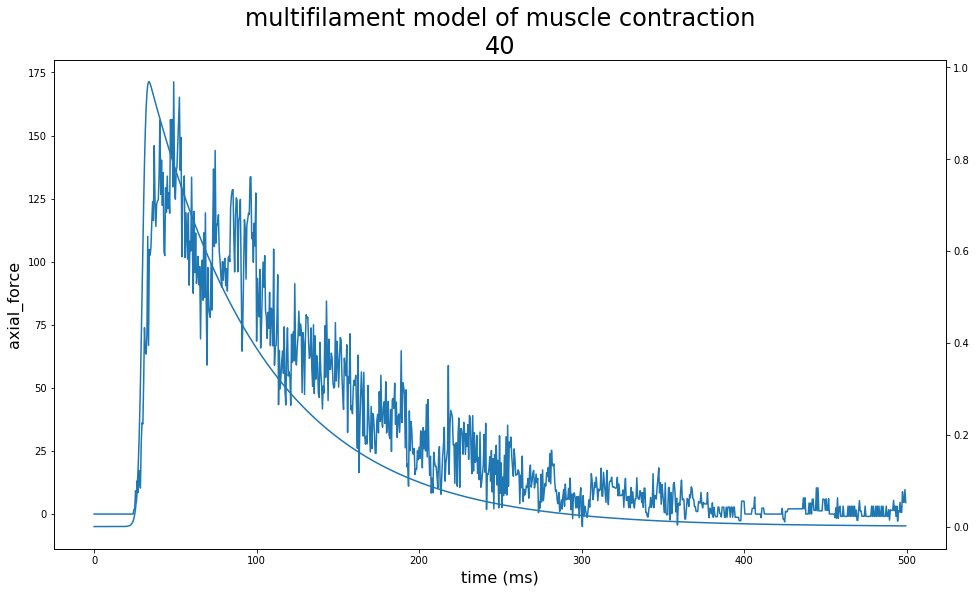

In [3]:
"""This code runs a single simulation"""
output_dir = "../_originalTransitionRates/"

stiffness = 40 # torsional spring
params = {"detachment_rate":"force_sensitive"} #"mh_c_ks":stiffness, "mh_c_kw":stiffness}

# check the comment to see what we are passing to it.
wl_meta = multifil.aws.metas.emit(output_dir, # local dir to save run output to
                                  None, #s3 bucket to upload results to
                                  time_trace, 
                                  0.5, # poisson ratio, set to const vol here
                                 None, # intial ls, using default by passing none
                                 length_trace, 
                                 actin_permissiveness_trace, 
                                 str(stiffness), # comment describing run
                                 True, # whether to write out resulting file 
                                  #or just pass back to variable
                                 params)
run_name = wl_meta['name']
print(run_name)
run_file = output_dir + run_name + ".meta.json"

for key in wl_meta.keys():
    print(key)

print(wl_meta['hs_params'])

run_manager = multifil.aws.run.manage(run_file, False) # have run.py create the sarc from meta
# Begin running
run_manager.run_and_save()   # with our new sarc, run it

print(run_name)
data_name = run_file.split('.meta')[0] + '.data.json'

with open(data_name, 'r') as file:
    data = json.load(file)

for key in data.keys():
    print(key, end=", ")

print()
print()
# print_constants(data['constants'])

key = "axial_force"
fs = 16

# recreate time trace in milliseconds
time_trace = data['timestep'].copy()
for i in range(len(time_trace)):
    time_trace[i] *= data['timestep_length']

# plot
fig, axes = plt.subplots(figsize=(16, 9))
axes.plot(time_trace, data[key])

title = "multifilament model of muscle contraction\n" + wl_meta['comment']
plt.title(title, fontsize=fs*1.5)
plt.xlabel("time (ms)", fontsize=fs)
plt.ylabel(key, fontsize=fs)

ax2 = plt.twinx()
ax2.plot(time_trace, data['actin_permissiveness'])

save = True # OI! make sure you know whats going on here in this statement
if save:
    plt.savefig(output_dir + str(run_name) + ".png")

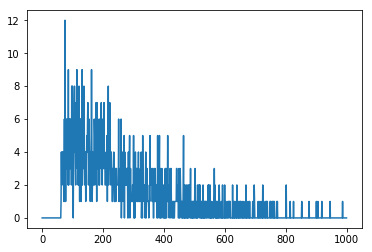

In [4]:
plt.plot(data['xb_trans_31'])

In [5]:
gutil.print_constants(data['constants'])

af
 	af_k = 1743 
 	af_k = 1743 
 	af_k = 1743 
 	af_k = 1743 
 	af_k = 1743 
 	af_k = 1743 
 	af_k = 1743 
 	af_k = 1743 
mf
 	mf_k = 2020 
 	mf_k = 2020 
 	mf_k = 2020 
 	mf_k = 2020 
mh


 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.27758101245984

mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 ,

mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_f

mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_fd_delta = 1.3 mh_fd_k0 = 0.10200000000000001 mh_g_ks = 2 mh_g_kw = 2 mh_g_rs = 16.47 mh_g_rw = 19.93 , 	 	detachment_rate = force_sensitive mh_c_ks = 40 mh_c_kw = 40 mh_c_rs = 1.2775810124598492 mh_c_rw = 0.8230972752405258 mh_f

 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
 	ti_a = 240 ti_b = 0.0045 
